In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Dataset download
tcs=yf.download('TCS.NS',start='2010-01-01',end='2024-12-31',interval='1mo')
icici=yf.download('ICICIBANK.NS',start='2010-01-01',end='2024-12-31',interval='1mo')

#save CSVs
tcs.to_csv('TCS_monthly.csv')
icici.to_csv('ICICI_monthly.csv')

tcs.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS
Date,,,,,
2010-01-01,280.871674,316.276302,265.725506,285.678759,111670096
2010-02-01,291.409180,297.816509,270.886612,280.908805,54282810
2010-03-01,298.619781,323.579674,288.807952,291.409132,74838560
2010-04-01,292.786224,319.371855,289.037440,300.800148,93376066
2010-05-01,284.236664,322.470240,262.126609,291.198659,63786312


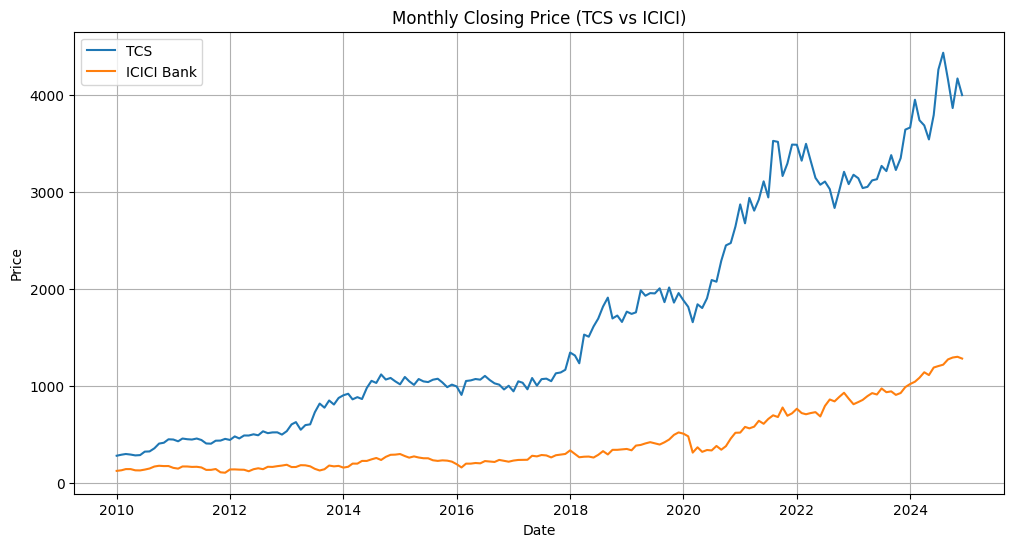

In [ ]:
#visualize

plt.figure(figsize=(12,6))
plt.plot(tcs['Close'],label='TCS')
plt.plot(icici['Close'], label='ICICI Bank')
plt.title("Monthly Closing Price (TCS vs ICICI)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Test for Stationarity: ADF test

from statsmodels.tsa.stattools import adfuller

def adf_test(series, title=''):
    print(f'--- ADF Test: {title} ---')
    result = adfuller(series.dropna())
    labels = ['ADF Statistic', 'p-value', '#Lags Used', 'Num of Observations']
    for val, label in zip(result[:4], labels):
        print(f'{label} : {val}')
    if result[1] <= 0.05:
        print("Series is Stationary")
    else:
        print("Series is Non-Stationary")

# Run ADF test on Close prices
adf_test(tcs['Close'], 'TCS Close')
adf_test(icici['Close'], 'ICICI Close')

--- ADF Test: TCS Close ---
ADF Statistic : 0.7442474315684917
p-value : 0.9906807739104463
#Lags Used : 11
Num of Observations : 168
Series is Non-Stationary
--- ADF Test: ICICI Close ---
ADF Statistic : 2.7212086718786748
p-value : 0.9990878434434037
#Lags Used : 5
Num of Observations : 174
Series is Non-Stationary


In [ ]:
#First difference to make the series stationary

tcs_diff=tcs['Close'].diff().dropna()
icici_diff=icici['Close'].diff().dropna()

In [ ]:
adf_test(tcs_diff,'TCS Close after 1st difference')
adf_test(icici_diff,'ICICI Close after 1st difference')

--- ADF Test: TCS Close after 1st difference ---
ADF Statistic : -3.4280269945276047
p-value : 0.01003974080408937
#Lags Used : 10
Num of Observations : 168
Series is Stationary
--- ADF Test: ICICI Close after 1st difference ---
ADF Statistic : -6.595703271512414
p-value : 6.9344447669612654e-09
#Lags Used : 2
Num of Observations : 176
Series is Stationary


In [ ]:
#Train & Test split

train_size=int(len(tcs)*0.8)
tcs_train=tcs_diff[:train_size]
tcs_test=tcs_diff[train_size:]
icici_train=icici_diff[:train_size]
icici_test=icici_diff[train_size:]

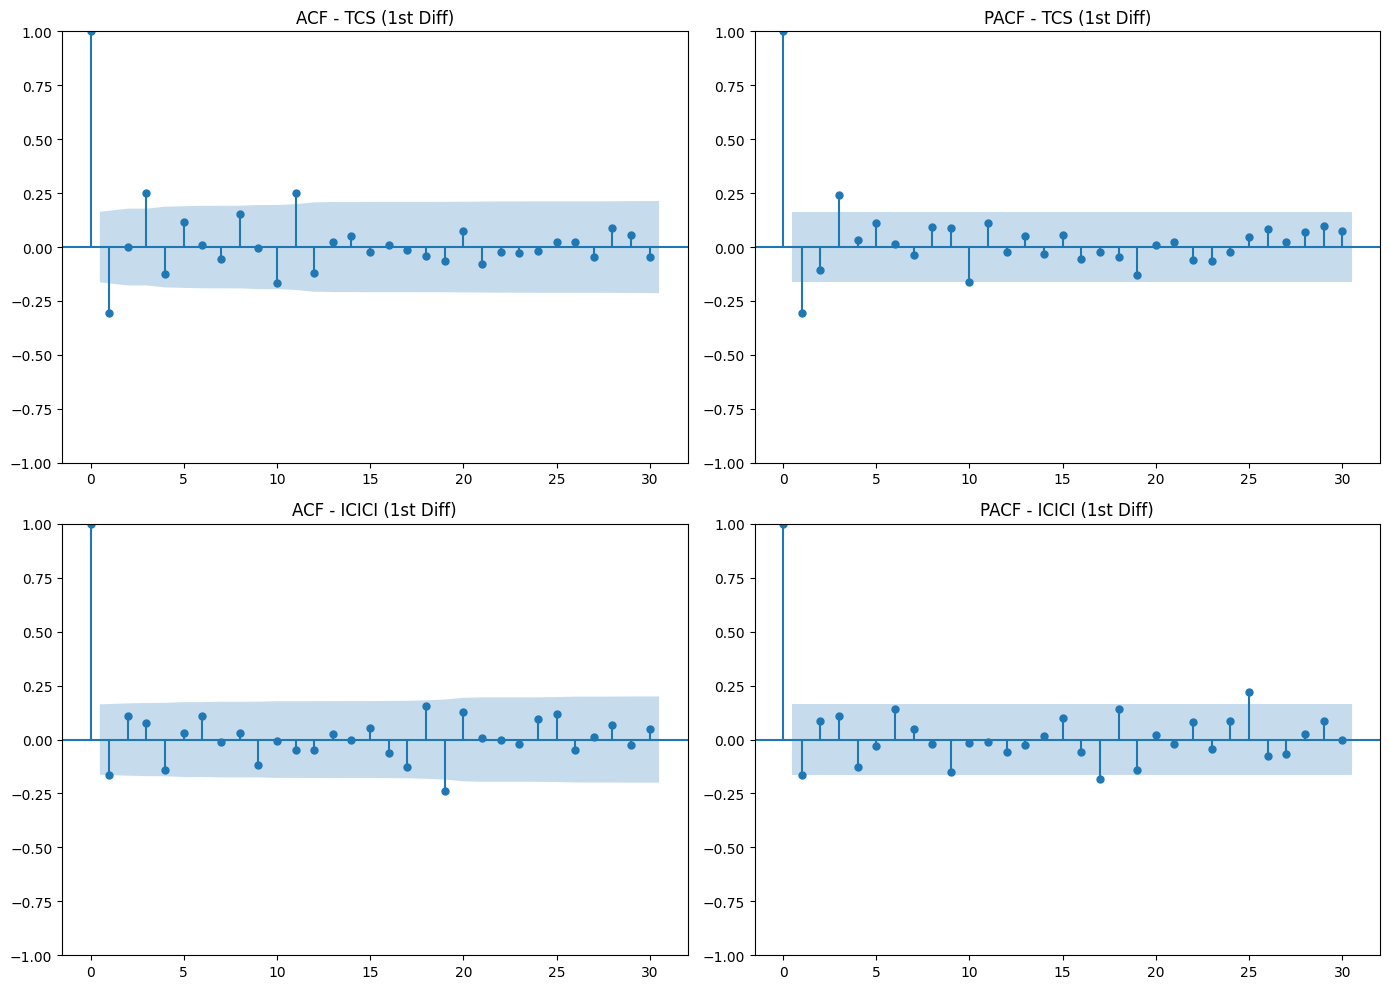

In [ ]:
#ACF/PACF plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# TCS - ACF
plot_acf(tcs_train, lags=30, ax=axes[0, 0])
axes[0, 0].set_title('ACF - TCS (1st Diff)')

# TCS - PACF
plot_pacf(tcs_train, lags=30, method='ywm', ax=axes[0, 1])
axes[0, 1].set_title('PACF - TCS (1st Diff)')

# ICICI - ACF
plot_acf(icici_train, lags=30, ax=axes[1, 0])
axes[1, 0].set_title('ACF - ICICI (1st Diff)')

# ICICI - PACF
plot_pacf(icici_train, lags=30, method='ywm', ax=axes[1, 1])
axes[1, 1].set_title('PACF - ICICI (1st Diff)')

plt.tight_layout()
plt.show()

In [ ]:
#fitting ARIMA
from statsmodels.tsa.arima.model import ARIMA

#TCS
tcs_arima=ARIMA(tcs_train,order=(1,1,1))
tcs_result=tcs_arima.fit()

#ICICI
icici_arima=ARIMA(icici_train,order=(1,1,1))
icici_result=icici_arima.fit()

In [ ]:
print(tcs_result.summary())
print(icici_result.summary())

                               SARIMAX Results                                
Dep. Variable:                 TCS.NS   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -858.282
Date:                Thu, 19 Jun 2025   AIC                           1722.563
Time:                        05:53:41   BIC                           1731.452
Sample:                    02-01-2010   HQIC                          1726.175
                         - 01-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3430      0.062     -5.541      0.000      -0.464      -0.222
ma.L1         -0.9487      0.016    -57.671      0.000      -0.981      -0.916
sigma2      9371.0745    597.740     15.678      0.0

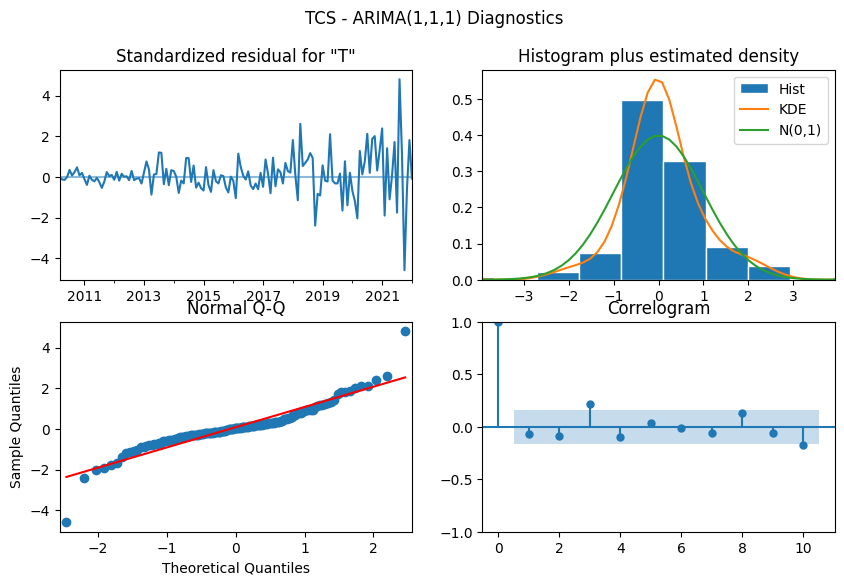

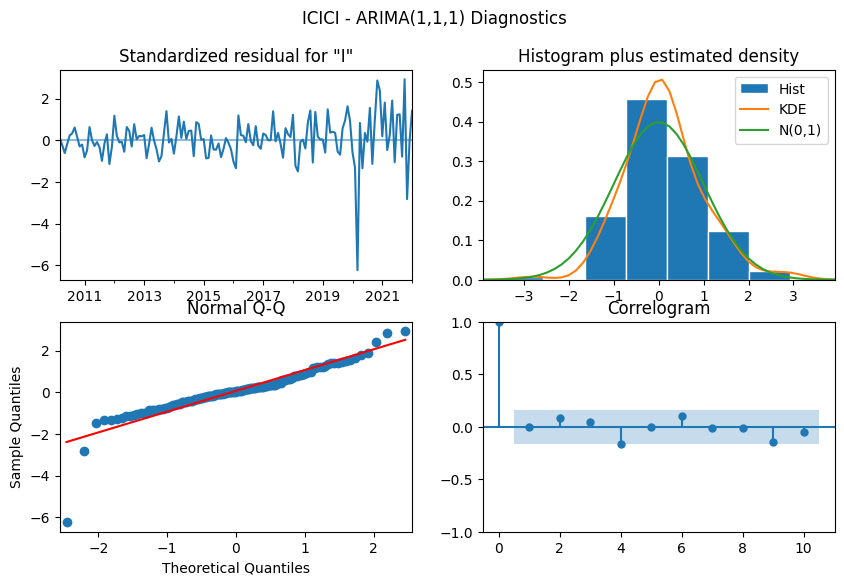

In [ ]:
tcs_result.plot_diagnostics(figsize=(10, 6))
plt.suptitle("TCS - ARIMA(1,1,1) Diagnostics")
plt.show()

icici_result.plot_diagnostics(figsize=(10, 6))
plt.suptitle("ICICI - ARIMA(1,1,1) Diagnostics")
plt.show()

In [ ]:
#Forecasting using ARIMA

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# ----- Forecast Function with Confidence Intervals -----
def forecast_plot(train, test, order, label):
    model = ARIMA(train, order=order)
    model_fit = model.fit()

    forecast_result = model_fit.get_forecast(steps=len(test))
    forecast_mean = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int()

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train, label='Train')
    plt.plot(test.index, test, label='Test', color='blue')
    plt.plot(test.index, forecast_mean, label='Forecast', color='red')
    plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1],
                     color='pink', alpha=0.3, label='95% Confidence Interval')
    plt.title(f'{label} - Forecast on Differenced Data (ARIMA{order})')
    plt.xlabel('Date')
    plt.ylabel('Differenced Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()



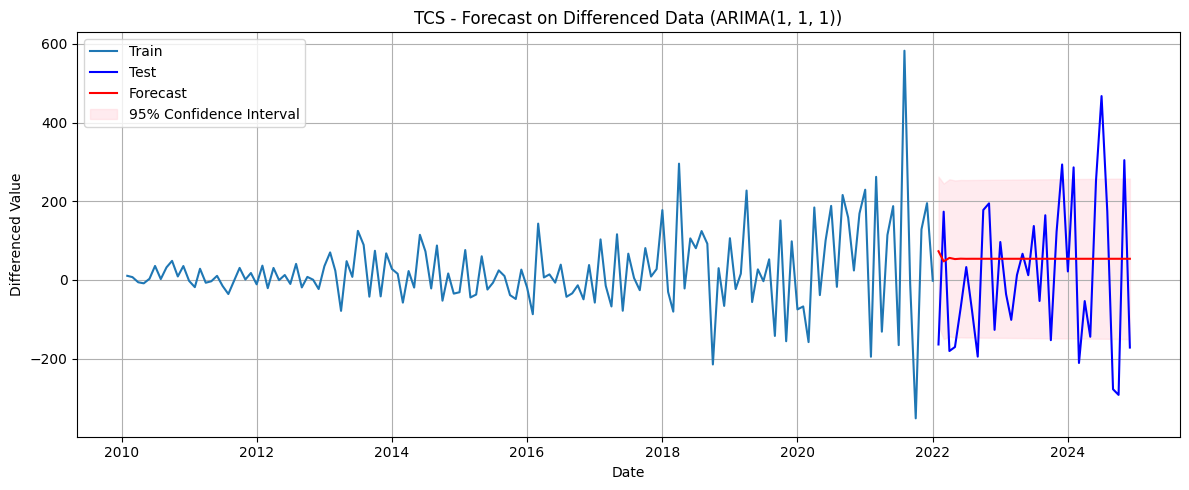

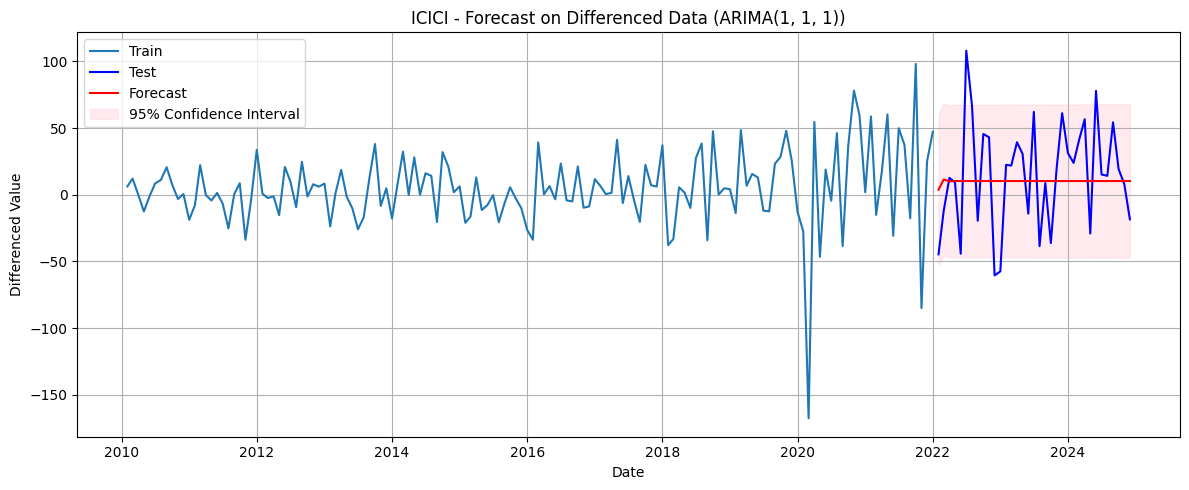

In [ ]:
forecast_plot(tcs_train,tcs_test,order=(1,1,1),label='TCS')
forecast_plot(icici_train,icici_test,order=(1,1,1),label='ICICI')

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

tcs_pred=tcs_arima.fit().forecast(steps=len(tcs_test))
icici_pred=icici_arima.fit().forecast(steps=len(icici_test))

print("MAE for TCS_ARIMA: ",mean_absolute_error(tcs_test,tcs_pred))
print("MAE for ICICI_ARIMA: ",mean_absolute_error(icici_test,icici_pred))

print("RMSE for TCS_ARIMA: ",np.sqrt(mean_absolute_error(tcs_test,tcs_pred)))
print("RMSE for ICICI_ARIMA: ",np.sqrt(mean_squared_error(icici_test,icici_pred)))

MAE for TCS_ARIMA:  163.2293075157787
MAE for ICICI_ARIMA:  32.526523483236105
RMSE for TCS_ARIMA:  12.776122554037226
RMSE for ICICI_ARIMA:  40.065820055469736


In [ ]:
from prophet import Prophet

# Function to prepare data for Prophet
def prepare_prophet_data(df, col='Close'):
    df_prophet = df[[col]].reset_index()
    df_prophet.columns = ['ds', 'y']
    return df_prophet

# Function to train/test split
def split_data_prophet(df, train_ratio=0.8):
    train_size = int(len(df) * train_ratio)
    train_df = df.iloc[:train_size]
    test_df = df.iloc[train_size:]
    return train_df, test_df

# Function to fit Prophet and forecast
def forecast_with_prophet(train_df, test_df, periods):
    model = Prophet()
    model.fit(train_df)

    future = model.make_future_dataframe(periods=periods, freq='M')
    forecast = model.predict(future)

    # Extract forecasted values for test period
    forecasted = forecast[['ds', 'yhat']].iloc[-periods:]
    forecasted = forecasted.set_index('ds')
    test_df = test_df.set_index('ds')

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(train_df['ds'], train_df['y'], label='Train')
    plt.plot(test_df.index, test_df['y'], label='Actual', color='blue')
    plt.plot(forecasted.index, forecasted['yhat'], label='Forecast', color='red')
    plt.title('Prophet Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluation
    mse = mean_squared_error(test_df['y'], forecasted['yhat'])
    mae = mean_absolute_error(test_df['y'], forecasted['yhat'])
    rmse = np.sqrt(mse)

    print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    return forecast, model


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoupd8fvg/8ooq59b5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoupd8fvg/wfd2tve4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47925', 'data', 'file=/tmp/tmpoupd8fvg/8ooq59b5.json', 'init=/tmp/tmpoupd8fvg/wfd2tve4.json', 'output', 'file=/tmp/tmpoupd8fvg/prophet_modelhn3ic1_j/prophet_model-20250619055352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:53:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:53:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


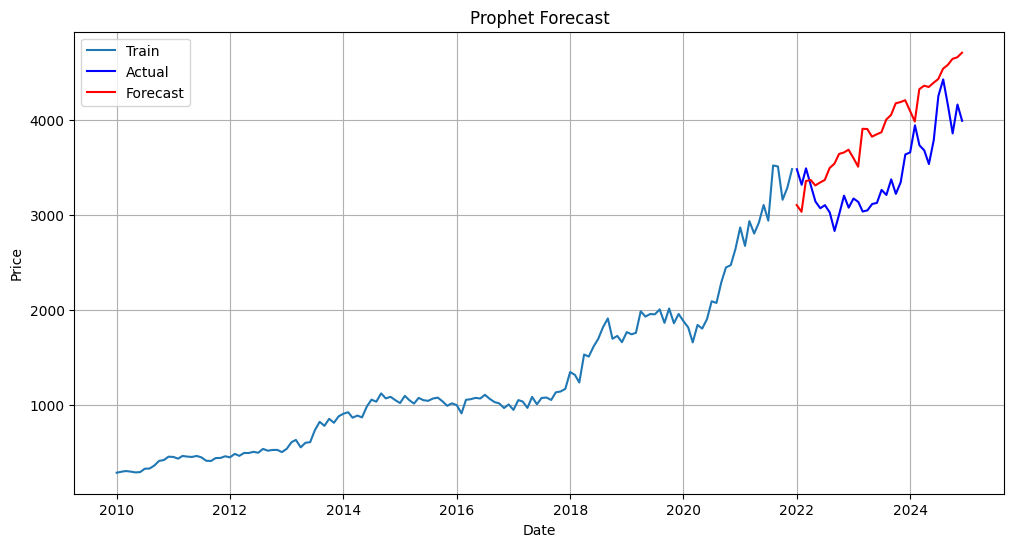

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoupd8fvg/r7a7thqf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoupd8fvg/cofpyfvk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94007', 'data', 'file=/tmp/tmpoupd8fvg/r7a7thqf.json', 'init=/tmp/tmpoupd8fvg/cofpyfvk.json', 'output', 'file=/tmp/tmpoupd8fvg/prophet_model40mc8gt5/prophet_model-20250619055354.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:53:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


MAE: 521.5087, RMSE: 578.8167


05:53:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


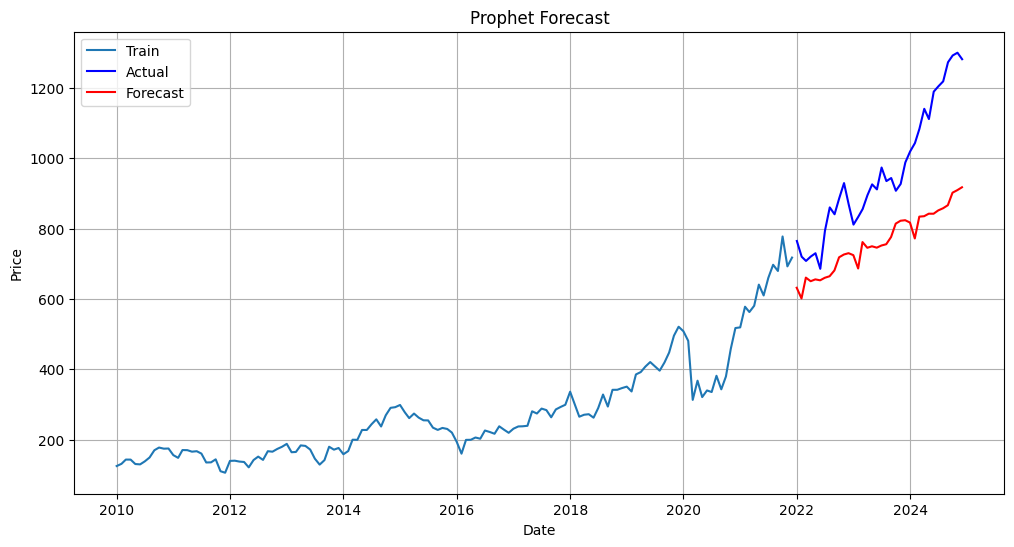

MAE: 198.2441, RMSE: 224.3412


In [ ]:
# Prepare prophet data
tcs_prophet = prepare_prophet_data(tcs, 'Close')
icici_prophet = prepare_prophet_data(icici, 'Close')

#Train & Test split
tcs_train,tcs_test = split_data_prophet(tcs_prophet)
icici_train, icici_test = split_data_prophet(icici_prophet)

#Forecast
tcs_prophet,model_tcs=forecast_with_prophet(tcs_train,tcs_test,periods=len(tcs_test))
icici_prophet,model_icici=forecast_with_prophet(icici_train,icici_test,periods=len(icici_test))

# **TCS VS ICICI FORECASTING USING LSTM**
---



In [ ]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
def prepare_lstm_data(series, time_step=36):
    X, y = [], []
    for i in range(len(series) - time_step):
        X.append(series[i:i + time_step])
        y.append(series[i + time_step])
    return np.array(X), np.array(y)

In [ ]:
#LSTM Model implementation

def lstm_forecast(df, company_name, time_step=36, epochs=50):
    data = df[['Close']].values
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data)

    #Prepare data with time steps
    X, Y= prepare_lstm_data(data_scaled, time_step)

    # Reshape for LSTM [samples, time steps, features]
    X = X.reshape(X.shape[0], X.shape[1], 1)

    total_months= len(X)
    train_split = int(total_months * 0.8)
    X_train, X_test = X[:train_split], X[train_split:]
    Y_train, Y_test = Y[:train_split], Y[train_split:]

    # Train-test split (80-20)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    Y_train, Y_test = Y[:split], Y[split:]

    # Define model
    model = Sequential()
    model.add(LSTM(50, return_sequences=False, input_shape=(X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=32, verbose=0)

    # Predict
    y_pred = model.predict(X_test)

    # Inverse transform
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1))

    forecast_start_index = len(df) - len(Y_test)
    forecast_index = df.index[forecast_start_index:]

    # Plot
    plt.figure(figsize=(12,6))
    # Plot training data up to the start of the forecast period
    plt.plot(df.index[:forecast_start_index], df['Close'].values[:forecast_start_index], label='Train', color='blue')
    # Plot actual test data
    plt.plot(forecast_index, y_test_inv, label='Test', color='black')
    # Plot forecasted data
    plt.plot(forecast_index, y_pred_inv, label='Forecast', color='red')
    plt.title(f'LSTM Forecast for {company_name}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()


    # Evaluate
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

    print(f"{company_name} - MAE: {mae:.2f}")
    print(f"{company_name} - RMSE: {rmse:.2f}")




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


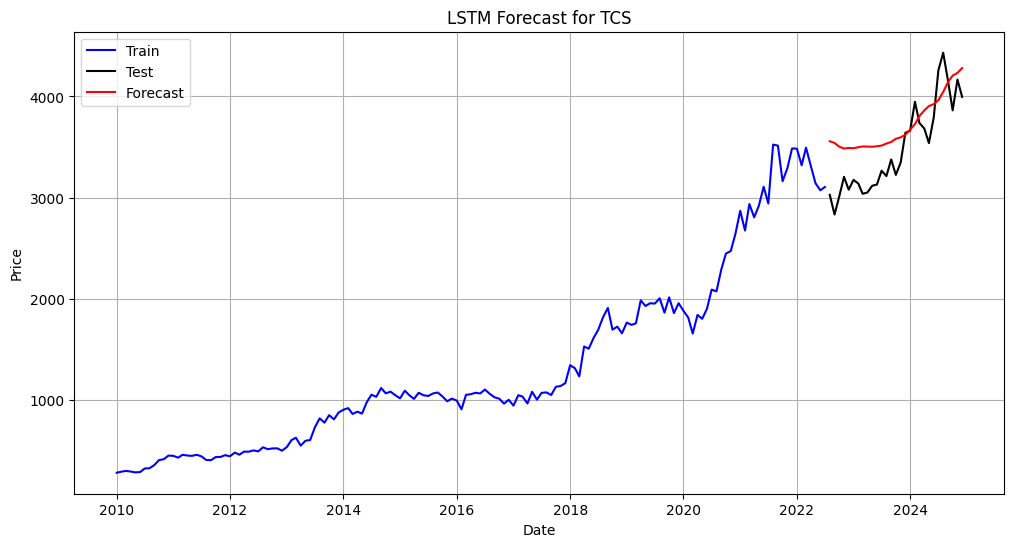

TCS - MAE: 293.77
TCS - RMSE: 336.28
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step


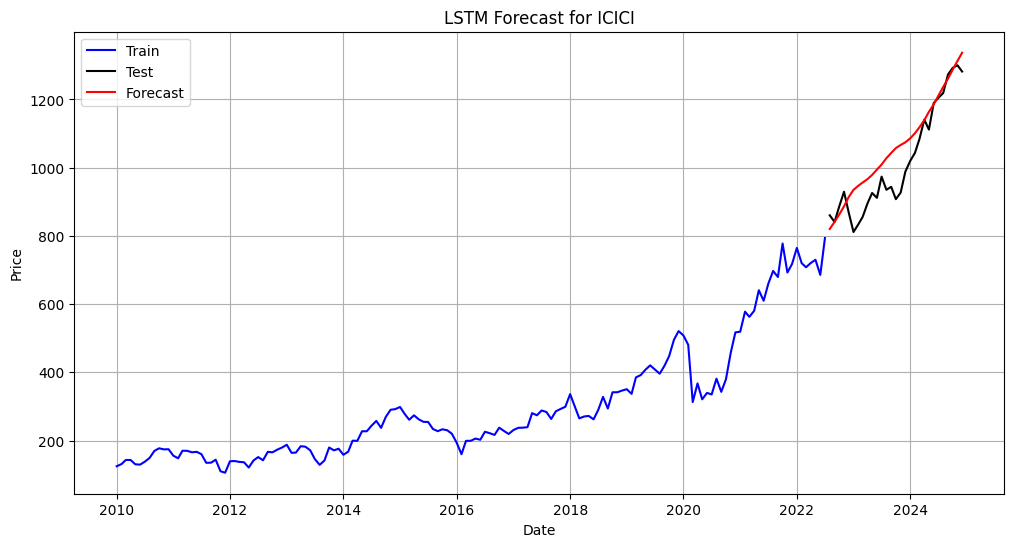

ICICI - MAE: 56.00
ICICI - RMSE: 70.30


In [ ]:
lstm_forecast(tcs, company_name='TCS',time_step=36,epochs=50)
lstm_forecast(icici, company_name='ICICI',time_step=36,epochs=50)

# New Section

In [ ]:
data = {
    'Model': ['ARIMA', 'Prophet', 'LSTM'],
    'TCS_MAE': [161.01, 469.3242 ,399.41],
    'ICICI_MAE': [32.52, 198.6918 , 40.39],
    'TCS_RMSE': [12.68, 523.9511 ,451.51],
    'ICICI_RMSE': [40.06,224.9132,47.45],
}

df = pd.DataFrame(data)

# Display the table
print(df)

     Model   TCS_MAE  ICICI_MAE  TCS_RMSE  ICICI_RMSE
0    ARIMA  161.0100    32.5200   12.6800     40.0600
1  Prophet  469.3242   198.6918  523.9511    224.9132
2     LSTM  399.4100    40.3900  451.5100     47.4500
